# Import Relevant Librys

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.nn.init as init
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.notebook import tqdm

/home/student/anaconda3/envs/Thesis-Kantorovich/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Cuda device if exist 

In [2]:
device = ["cuda" if torch.cuda.is_available() else "cpu"]
print(device)

['cuda']


# Load and transform MNIST Data set

In [3]:
down_flag = False # (Optional) usually false

# Define a transform to normalize the data
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
train_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=True, transform=transform)
# Download and load the test data
test_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=False, transform=transform)


# Iterating and Visualizing the Dataset

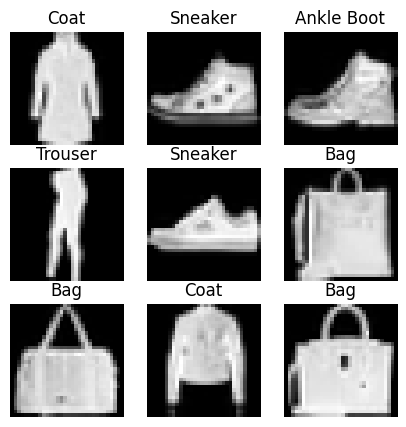

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (5,5))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

Split to train and valid in addition prepare dataloader for training

In [5]:
# Hyper-parameters
batch_size = 64
valid_size = 0.2

# Prepare valid 
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sample = SubsetRandomSampler(train_idx)
valid_sample = SubsetRandomSampler(valid_idx)

# Data Loader
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sample, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(train_data, sampler=valid_sample, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Build LeNet5 

In [6]:
class LeNet5(nn.Module):
    def __init__(self, useDrop=False, useBatchNorm=False):
        super(LeNet5, self).__init__()
        # Define Configuration Param
        self.useDrop = useDrop
        self.useBatchNorm = useBatchNorm
        # Define NN elements 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
        self.linear1 = nn.Linear(in_features=120, out_features=84)
        self.linear2 = nn.Linear(in_features=84, out_features=10)


        if self.useBatchNorm:
            self.bn1 = nn.BatchNorm2d(6)
            self.bn2 = nn.BatchNorm2d(16)
            self.bn3 = nn.BatchNorm2d(120)

        if self.useDrop:
            self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        if self.useBatchNorm:
            x = self.bn1(x)
        x = self.pool(F.relu(x))
        # Layer 2
        x = self.conv2(x)
        if self.useBatchNorm:
            x = self.bn2(x)
        x = self.pool(F.relu(x))
        # Layer 3
        x = self.conv3(x)
        if self.useBatchNorm:
            x = self.bn3(x)
        x = F.relu(x)
        # Layer 4
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        if self.useDrop:
            x = self.dropout(x)
        x = F.relu(self.linear1(x))
        # Layer 5 output 
        x = F.relu(self.linear2(x))

        return x


# Train Loop

In [7]:
def TrainLoop(train_loader, 
              valid_loader, 
              useDrop=False, useBatchNorm=False, use_Weight_decay=False,
              num_epochs=10,
              lr_init=0.001,
              PATH = './LeNet5.pth'):
    #Initalize gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Define the model
    model = LeNet5(useDrop=False, useBatchNorm=False)
    print(model)
    model.to(device)

    # Define Optimizer
    if use_Weight_decay:
        l2_reg = 0.0001
    else:
        l2_reg = 0.0
    optimizer = optim.Adam(model.parameters(), lr=lr_init, betas=(0.9, 0.999), weight_decay=l2_reg)

    # Define creterion cross entropy 
    criterion = nn.CrossEntropyLoss()

    # define lists to store losses and accuracies
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Start Train Loop
    for epoch in range(num_epochs):
        model.train()
        # initialize variables to store the loss and accuracy
        train_loss = 0.0
        train_correct = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            # Zero grad
            optimizer.zero_grad()
            # Foward-prop
            output = model(data)
            # Calc loss
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # update the parameters
            optimizer.step()

            # calculate the accuracy
            _, predicted = torch.max(output.data, 1)
            train_correct += (predicted == target).sum().item()

            # add the batch loss to the epoch loss
            train_loss += loss.item()

        # calculate the average loss and accuracy for the epoch
        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)

        # set the network to evaluation mode
        model.eval()
        # initialize variables to store the loss and accuracy
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # send the data and target to the device (CPU or GPU)
                data, target = data.to(device), target.to(device)

                # forward pass
                output = model(data)

                # calculate the loss
                loss = criterion(output, target)

                # calculate the accuracy
                _, predicted = torch.max(output.data, 1)
                val_correct += (predicted == target).sum().item()

                # add the batch loss to the epoch loss
                val_loss += loss.item()

        # calculate the average loss and accuracy for the epoch
        val_loss /= len(valid_loader)
        val_acc = val_correct / len(valid_loader.dataset)
        # print the losses and accuracies for the epoch
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
            .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

        # store the losses and accuracies for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    # Finally save weights
    torch.save(model.state_dict(), PATH)
    # return results for ploting
    return train_losses, val_losses, train_accs, val_accs

Run simple try without any batchnorm or dropout

In [9]:
train_losses_simple, val_losses_simple, train_accs_simple, val_accs_simple = TrainLoop(train_loader, 
                                                                                        valid_loader, 
                                                                                        useDrop=False, useBatchNorm=False, use_Weight_decay=False,
                                                                                        num_epochs=30,
                                                                                        lr_init=0.001,
                                                                                        PATH = './LeNet5(simple).pth')

LeNet5(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
)
Epoch [1/30], Train Loss: 1.4554, Train Acc: 0.3444, Val Loss: 1.3481, Val Acc: 0.0917
Epoch [2/30], Train Loss: 1.2862, Train Acc: 0.3854, Val Loss: 1.2613, Val Acc: 0.0983
Epoch [3/30], Train Loss: 1.2407, Train Acc: 0.3976, Val Loss: 1.2239, Val Acc: 0.1009
Epoch [4/30], Train Loss: 1.2125, Train Acc: 0.4038, Val Loss: 1.2112, Val Acc: 0.1020
Epoch [5/30], Train Loss: 1.1922, Train Acc: 0.4087, Val Loss: 1.1952, Val Acc: 0.1028
Epoch [6/30], Train Loss: 1.1772, Train Acc: 0.4127, Val Loss: 1.1942, Val Acc: 0.1028
Epoch [7/30], Train Loss: 1.1632, Train Acc: 0.4171, Val Loss: 1.1982, Va